# Importing 

In [2]:
# ************* Importing ***************
# Libraries
from google.colab import drive
import pandas as pd
import numpy as np
import os
import matplotlib.pyplot as plt
import graphviz # Found to visualize the tree structures
from PIL import Image

# ML Libraries
import tensorflow as tf
from tensorflow import keras
from sklearn.linear_model import LogisticRegression
# Found as alternative to PCA when there is sparse input type
from sklearn.decomposition import TruncatedSVD
from sklearn.tree import DecisionTreeClassifier, export_graphviz
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, f1_score, confusion_matrix
from sklearn.model_selection import cross_val_score
# Found this is a very common method of converting text features to usable numeric features and Sklearn has a handy function so we chose it
from sklearn.feature_extraction.text import TfidfVectorizer 

# Setting up Google Drive connection
drive.mount('/content/drive/')

# Pathing to our project folder in Google Drive
GOOGLE_DRIVE_PATH_AFTER_MYDRIVE = 'Colab Notebooks/CS254 - Final Project/Project/'
GOOGLE_DRIVE_PATH = os.path.join('drive', 'MyDrive', GOOGLE_DRIVE_PATH_AFTER_MYDRIVE)
#print(os.listdir(GOOGLE_DRIVE_PATH))

# Import our Dataset into pandas df
data = pd.read_csv(GOOGLE_DRIVE_PATH + "CS_254_Seeded_Dataset.csv")
# data = pd.read_csv("./CS_254_Seeded_Dataset.csv")
# Test display of the dataset
#display(data.head())

Mounted at /content/drive/


---
## Data Processing

In [3]:
# ************* Data Processing ***************

# Drop the ID column (always)
data = data.drop('Message ID', axis=1)

# **************Testing weights ******************
data = data.drop('Date', axis=1) # Removes date
# data = data.drop('Subject', axis=1) # Removes subject
# data = data.drop('Message', axis=1) # Removes body

# Split the dataset into features (X) and targets (y)
# Kept getting a value error due to NaN's in the data and while researching discovered this built in pandas function to fix
X = data.iloc[:, :-1].fillna("")
y = data.iloc[:, -1]

# Test display of X and y
display(X)
display(y)

# After researching multiple errors, a recommendation to fuse all text columns into one seemed to fix them.
# Apparently the number of features can get way too high when using tfidf otherwise
if len(data.columns) > 1:
  X = X.apply(' '.join, axis=1)

,Subject,Message
0,christmas tree farm pictures,
1,"vastar resources , inc .","gary , production from the high island larger ..."
2,calpine daily gas nomination,- calpine daily gas nomination 1 . doc
3,re : issue,fyi - see note below - already done .\nstella\...
4,meter 7268 nov allocation,fyi .\n- - - - - - - - - - - - - - - - - - - -...
...,...,...
33823,CLICK NOW,"Dear user, This is to notify all Students and ..."
33824,An Imperative Task,Hi\r\n\r\nIs your schedule open today? I’m hea...
33825,Colin Fitzgerald,Are you available? I have a request I need you...
33826,CLICK NOW,"Dear user, This is to notify all Students and ..."


0        0
1        0
2        0
3        0
4        0
        ..
33823    1
33824    1
33825    1
33826    1
33827    1
Name: Spam, Length: 33828, dtype: int64

---
# Logistic Regression, Decision Tree, Random Forest

---
## Create Numerical Features

In [4]:
# Convert text features to numeric features using sklearn TFIDF vectorizer
tfidf = TfidfVectorizer()
X_vectorized = tfidf.fit_transform(X)


## Splitting and Training

In [5]:
# ************* Splitting and Training ***************
# These are just standard tests to make sure the code to make and use the models work

# Split the dataset into training and testing sets
t_size = .30
X_train, X_test, y_train, y_test = train_test_split(X_vectorized, y, test_size=t_size, random_state=42376)

# Tuning Variables:
max_iter = 500
max_depth = 30
n_estimators = 50


# Create classifiers in an iteratable python dictionary for the for loop
models = {
    "Logistic Regression Classifier": LogisticRegression(max_iter=max_iter),
    "Decision Tree Classifier": DecisionTreeClassifier(max_depth=max_depth),
    "Random Forest Classifier": RandomForestClassifier(n_estimators=n_estimators, max_depth=max_depth)
}

# Confirm valid and compatible shapes
print("X_train shape:", X_train.shape)
print("y_train shape:", y_train.shape)


# Loop through the models, fit them, and calculate their accuracy
for model_name, model in models.items():
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    accuracy = accuracy_score(y_test, y_pred)
    print(f"{model_name} accuracy: {accuracy:.5f}")

X_train shape: (23679, 158516)
y_train shape: (23679,)
Logistic Regression Classifier accuracy: 0.98217
Decision Tree Classifier accuracy: 0.95261
Random Forest Classifier accuracy: 0.95625



## Plotting

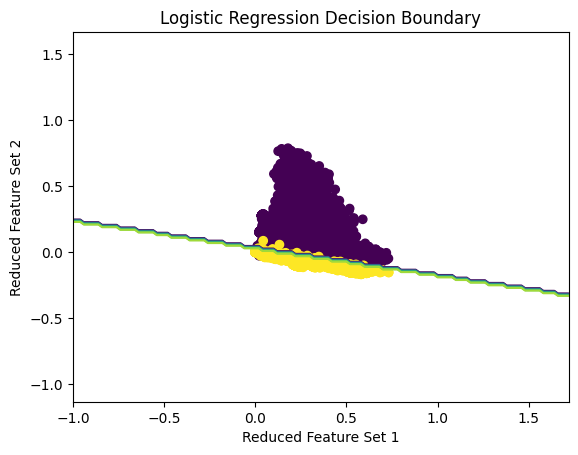

In [6]:
# ************* Plotting ***************

# It took a lot of trial and error to get this plot working, and I think it sadly,
# just isn't very helpful due to the hyperdimensiality of our TF-IDF features.

# Reduce the data into a 2D so we can plot it
# PCA was attempted but apparently it can not work on sparse input type
# SVD was offered online as a substitute for PCA when you have sparse input type
svd = TruncatedSVD(n_components=2)
X_svd = svd.fit_transform(X_train)

svd = TruncatedSVD(n_components=2)
X_full_svd = svd.fit_transform(X_vectorized)

# Train the logistic regression model on the 2D dataset
log_reg = LogisticRegression(max_iter=max_iter)
log_reg.fit(X_svd, y_train)

# Create a mesh grid for the decision boundary plot
h = .02
x_min, x_max = X_svd[:, 0].min() - 1, X_svd[:, 0].max() + 1
y_min, y_max = X_svd[:, 1].min() - 1, X_svd[:, 1].max() + 1

xx, yy = np.meshgrid(np.arange(x_min, x_max, h), np.arange(y_min, y_max, h))

# Calculate the decision boundary
Z = log_reg.predict(np.c_[xx.ravel(), yy.ravel()])
Z = Z.reshape(xx.shape)

# Plot the decision boundary
plt.contour(xx, yy, Z)
plt.scatter(X_full_svd[:, 0], X_full_svd[:, 1], c=y, cmap='viridis')

# Add axis labels and a title
plt.xlabel('Reduced Feature Set 1')
plt.ylabel('Reduced Feature Set 2')
plt.title('Logistic Regression Decision Boundary')

# Display the plot
plt.show()


## Tree Visualizing Graphs

In [7]:
# ************* Tree Visualizing Graphs ***************

sorted_by_weight_HtL = np.argsort(models['Decision Tree Classifier'].feature_importances_)[::-1]
sorted_top_10 = sorted_by_weight_HtL[:10]

# Check what the key words are
for word in sorted_top_10:
  print(tfidf.get_feature_names_out()[word])

enron
2001
attached
hourahead
vince
thanks
http
gas
louise
your


In [8]:
# Create visualized structure of decision tree and display it ** THIS WILL BE HUGE / TAKE TIME TO GEN ** CMD/CTRL & - until you can see the structure **
dtmodel = export_graphviz(models['Decision Tree Classifier'], out_file=None, filled=True, rounded=True, class_names=['0', '1'])
graph = graphviz.Source(dtmodel)
graph.render('decision_tree', format='png')
import cv2
from google.colab.patches import cv2_imshow
# Read the image using OpenCV
img = cv2.imread('decision_tree.png')
cv2.resize(img, (1600, 1200))

# Display the image
cv2_imshow(img)
# I wanted to see if I could visual the random forest but the image was easily over 10GB in size and could not be displayed

Output hidden; open in https://colab.research.google.com to view.

In [9]:
log_array = np.zeros(19)
dt_array = np.zeros(19)
rf_array = np.zeros(19)
index = 0

for i in range(5, 100, 5):
    t_size = ((100 - i)/100)
    print(f"{100 - i}% left to go")
    X_train, X_test, y_train, y_test = train_test_split(X_vectorized, y, test_size=t_size, random_state=42376)

    # Create classifiers in an iteratable python dictionary for the for loop
    models = {
      "Logistic Regression Classifier": LogisticRegression(max_iter=max_iter),
      "Decision Tree Classifier": DecisionTreeClassifier(max_depth=max_depth),
      "Random Forest Classifier": RandomForestClassifier(n_estimators=n_estimators, max_depth=max_depth)
    }

    # Loop through the models, fit them, and calculate their accuracy
    for model_name, model in models.items():
        model.fit(X_train, y_train)
        y_pred = model.predict(X_test)
        f1 = f1_score(y_test, y_pred, average='micro')
        if model_name == "Logistic Regression Classifier":
            log_array[index] = f1
        if model_name == "Decision Tree Classifier":
            dt_array[index] = f1
        if model_name == "Random Forest Classifier":
            rf_array[index] = f1
    index+=1
    
display(log_array)
display(dt_array)
display(rf_array)

95% left to go
90% left to go
85% left to go
80% left to go
75% left to go
70% left to go
65% left to go
60% left to go
55% left to go
50% left to go
45% left to go
40% left to go
35% left to go
30% left to go
25% left to go
20% left to go
15% left to go
10% left to go
5% left to go


array([0.96281545, 0.96948696, 0.97322112, 0.97605587, 0.97686335,
       0.97749155, 0.97962618, 0.98103168, 0.98183382, 0.98226321,
       0.98252644, 0.98241206, 0.98226351, 0.98216573, 0.98261795,
       0.98226426, 0.98187192, 0.98019509, 0.97813239])

array([0.89404736, 0.9245221 , 0.9341309 , 0.93407974, 0.94213866,
       0.94227196, 0.93924235, 0.94146918, 0.94851123, 0.95140121,
       0.95165211, 0.95085723, 0.95185811, 0.95260617, 0.95388436,
       0.95211351, 0.95133005, 0.94531481, 0.94858156])

array([0.94703924, 0.94702096, 0.9516589 , 0.95144662, 0.95502739,
       0.95130912, 0.95529583, 0.96009262, 0.95479953, 0.956604  ,
       0.95703869, 0.96401123, 0.95498311, 0.95556212, 0.95565803,
       0.95802542, 0.94817734, 0.94797517, 0.95449173])

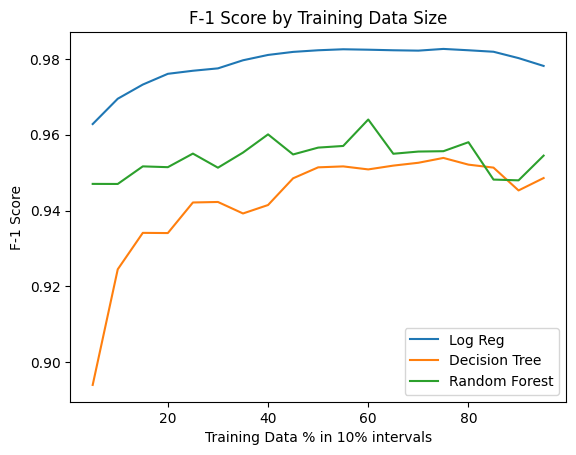

In [10]:
# Shift the index values by 1 to like up with x0%
x = np.arange(5, 100, 5)

# Plot all three arrays
plt.plot(x, log_array, label='Log Reg')
plt.plot(x, dt_array, label='Decision Tree')
plt.plot(x, rf_array, label='Random Forest')

# Add legend and axis labels
plt.legend()
plt.xlabel('Training Data % in 10% intervals')
plt.ylabel('F-1 Score')
plt.title('F-1 Score by Training Data Size')

# Show the plot
plt.show()


## Cross Validation Testing & Hyperparam Tweaking

In [11]:
# ************* Cross - Val Testing and Hyperparam tweaking ***************

# for i in range(100):
  # scores = cross_val_score()

*italicized text*---
# Neural Network

## Create Numerical Features

In [12]:
# Convert text features to numeric features using sklearn TFIDF vectorizer
tfidf = TfidfVectorizer(max_features=14000, lowercase=True, analyzer='word',)
X_vectorized = tfidf.fit_transform(X)

# Convert the sparse matrix to a dense array
X_dense = X_vectorized.toarray()

# Split the dataset into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X_vectorized.toarray(), y, test_size=0.5, random_state=66)

## Model Creation

In [13]:
model = keras.Sequential([
    keras.layers.Dense(16, activation='relu', input_shape=(X_train.shape[1],)),
    keras.layers.BatchNormalization(),
    keras.layers.Dropout(0.5),
    keras.layers.Dense(1, activation='sigmoid')
])
# Aadam optimizer with binary crossentropy loss function
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

In [14]:
# ************* Model Training ***************
# early stopping to prevent overfitting, not activated in current model version.... 
early_stopping = keras.callbacks.EarlyStopping(patience=10,min_delta=0.001,restore_best_weights=True,)

# probably change the validation split?
history = model.fit(X_train, y_train, epochs=10, batch_size=64, validation_split=0.5)

Epoch 1/10
133/133 [==============================] - 9s 14ms/step - loss: 0.1688 - accuracy: 0.9450 - val_loss: 0.4985 - val_accuracy: 0.9863
Epoch 2/10
133/133 [==============================] - 1s 7ms/step - loss: 0.0402 - accuracy: 0.9916 - val_loss: 0.2974 - val_accuracy: 0.9890
Epoch 3/10
133/133 [==============================] - 1s 7ms/step - loss: 0.0194 - accuracy: 0.9980 - val_loss: 0.1181 - val_accuracy: 0.9879
Epoch 4/10
133/133 [==============================] - 1s 7ms/step - loss: 0.0109 - accuracy: 0.9988 - val_loss: 0.0455 - val_accuracy: 0.9883
Epoch 5/10
133/133 [==============================] - 1s 7ms/step - loss: 0.0069 - accuracy: 0.9993 - val_loss: 0.0364 - val_accuracy: 0.9875
Epoch 6/10
133/133 [==============================] - 1s 8ms/step - loss: 0.0047 - accuracy: 0.9998 - val_loss: 0.0372 - val_accuracy: 0.9875
Epoch 7/10
133/133 [==============================] - 1s 8ms/step - loss: 0.0038 - accuracy: 0.9998 - val_loss: 0.0379 - val_accuracy: 0.9879
Epoch

## Plots and Graphs

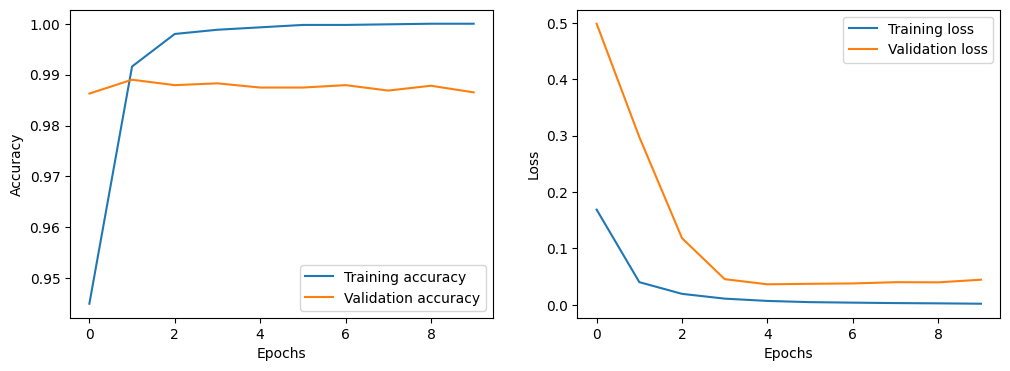

529/529 [==============================] - 1s 2ms/step


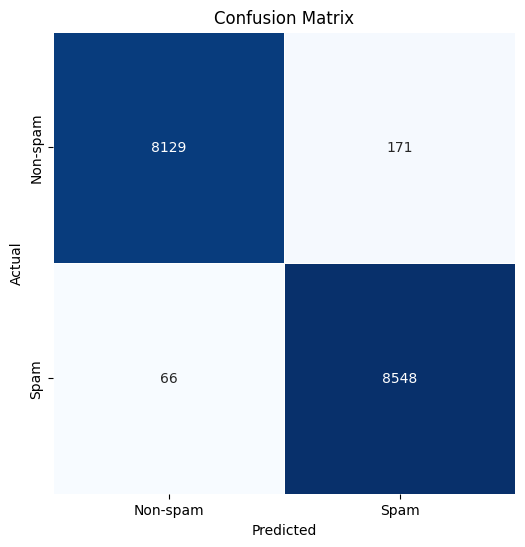

In [15]:
plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Training accuracy')
plt.plot(history.history['val_accuracy'], label='Validation accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Training loss')
plt.plot(history.history['val_loss'], label='Validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

# shows confusion matrix and classification report of model
import seaborn as sns
y_pred = (model.predict(X_test) > 0.5).astype("int32")
cm = confusion_matrix(y_test, y_pred)

plt.figure(figsize=(6, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', square=True, linewidths=0.5, cbar=False, xticklabels=['Non-spam', 'Spam'], yticklabels=['Non-spam', 'Spam'])
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix')
plt.show()

In [16]:
# Extract feature importances from the first hidden layer
importance_weights = np.abs(model.layers[0].get_weights()[0]).sum(axis=1)
feature_names = np.array(tfidf.get_feature_names_out())
top_20_indices = np.argsort(importance_weights)[-20:]

# Create a DataFrame to display the top 10 features and their importances
top_20_features = pd.DataFrame({'word': feature_names[top_20_indices], 'importance': importance_weights[top_20_indices]})
top_20_features.sort_values(by='importance', ascending=False, inplace=True)

# Display the top 10 features
display(top_20_features)

,word,importance
19,attached,1.388144
18,enron,1.190106
17,louise,1.157036
16,vince,1.125383
15,thanks,1.104222
14,713,0.998108
13,2005,0.982628
12,2001,0.958738
11,mobile,0.951518
10,2004,0.942122


Ensemble Model and Results

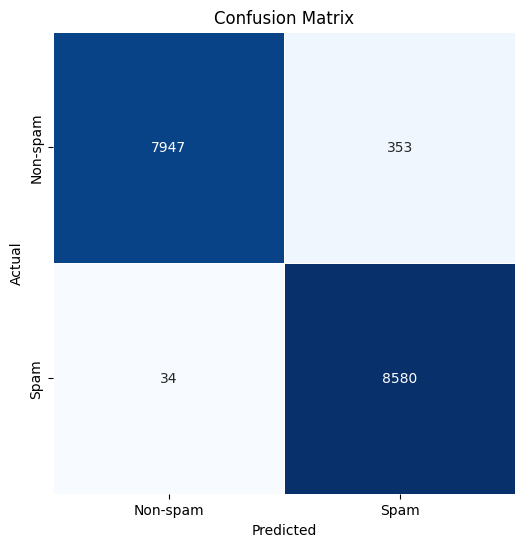

In [24]:
from sklearn.ensemble import VotingClassifier

# Convert text features to numeric features using sklearn TFIDF vectorizer
tfidf = TfidfVectorizer(max_features=14000, lowercase=True, analyzer='word',)
X_vectorized = tfidf.fit_transform(X)

# Convert the sparse matrix to a dense array
X_dense = X_vectorized.toarray()

# Split the dataset into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X_dense, y, test_size=0.5, random_state=66)

# Define the model architecture
model = keras.Sequential([
    keras.layers.Dense(16, activation='relu', input_shape=(X_train.shape[1],)),
    keras.layers.BatchNormalization(),
    keras.layers.Dropout(0.5),
    keras.layers.Dense(1, activation='sigmoid')
])

# Compile the model with binary cross-entropy loss and Adam optimizer
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

# Define the scikit-learn models for the ensemble
models = {
    "Logistic Regression Classifier": LogisticRegression(max_iter=500),
    "Decision Tree Classifier": DecisionTreeClassifier(max_depth=30),
    "Random Forest Classifier": RandomForestClassifier(n_estimators=50, max_depth=30)
}

# Train the models and create an ensemble
ensemble = VotingClassifier(estimators=[
    ('lr', models["Logistic Regression Classifier"]), 
    ('dt', models["Decision Tree Classifier"]), 
    ('rf', models["Random Forest Classifier"]), 
    ], 
    voting='hard')

ensemble.fit(X_train, y_train)

# Make predictions on test data
y_pred = ensemble.predict(X_test)

# Generate confusion matrix and classification report
cm = confusion_matrix(y_test, y_pred)

# Plot confusion matrix
plt.figure(figsize=(6, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', square=True, linewidths=0.5, cbar=False, xticklabels=['Non-spam', 'Spam'], yticklabels=['Non-spam', 'Spam'])
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix')
plt.show()

